# Circularities

What qualifies as a disk in TNG50 and how is that determined? "Disk stars" are commonly held to possess a circularity parameter $ϵ > 0.7$. When the majority of stars in a galaxy are "disk stars", the galaxy possess a stellar disk. But how do we calculate that circularity in TNG50? A supplementary catalog created by Genel et al. 2015 (G15) is freely available to determine disks, with the consideration that minimum subhalo stellar mass in its study is $3.4 \times 10^8 M_{sun}$. Our broader research in TNG50 considers disks within tumbling halo potentials using a catalog of 1754 systems created by Ash & Valluri 2023 (AV23), and G15 only yields 51 disks at present time to study. It appears broadly unphysical for such a low percentage of systems to possess stellar disks --- which is remedied by the the fact the two catalogs only have 550 systems in common with their samples. AV23's galaxies are on the whole, not massive enough for G15's study. 

Stellar specific angular momentum (of which we plot the total sum for each system with the defined boundaries) for a given star is defined below for stellar mass $M_*$, radial coordinate $r_*$, velocity $v_*$, and angular momentum $J_*$:

$$  j_* = \frac{J_*}{M_*} = r \times v$$

In [1]:
import sys
import h5py
import illustris_python as il 
import numpy as np
import scipy.stats as stats
from scipy.spatial.transform import Rotation as R 
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('mplstyle.txt')
import agama

sys.path.append('/home/tnguser/python/')


Bad key frameon in file mplstyle.txt, line 23 ('frameon: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


In [2]:
sim = 'L35n2160TNG' # simulation name
startSnap = 75 # starting snapshot for principal & pattern files
snapIdx = 24 # index of most recent snapshot (z=0)
basePath = '/home/tnguser/sims.TNG/' + sim + '/output' #calling on simulations

In [3]:
# Halos in Neil Ash's catalog
save_name = '/home/tnguser/postprocessing/circularity_study/'
catalogue_path = '/home/tnguser/postprocessing/halocatalogues/' + sim + '.npy'
naive_halos = np.load(catalogue_path)
# getting IDs of halos in halo catalogue which are "disky"
filename = "./stellar_circs.hdf5" # supplementary stellar circularity information
hf=h5py.File(filename,'r')
circ_subfindID = hf['Snapshot_99']['SubfindID']
circ07 = hf['Snapshot_99']['CircAbove07Frac']
disky_temp = circ_subfindID[np.where(np.array(circ07) > 0.5)] # definition of "disky" halos
main_subhalos = np.load('/home/tnguser/postprocessing/halocatalogues/' + sim + '_mainSubhalos.npy') #subfindIDs of halos in Neil's catalogue
diskyIDs = np.intersect1d(disky_temp,main_subhalos) # final set of subfindIDs
diskyIDs = np.delete(diskyIDs, [1, 10, 11, 14, 16, 23, 25, 26, 32, 34, 57, 58])
print(len(diskyIDs))

51


In [4]:
def snapshot_redshift_corr(basePath,startSnap=75):
    """
    Calls and stores z = and redshift values
    """
    redshift_space = []
    for snapshot_number in range(startSnap,100):
        header=il.groupcat.loadHeader(basePath,snapshot_number) 
        redshift_space.append(header.get('Redshift')) 
    return np.arange(startSnap,100), np.array(redshift_space) 

def value(arr):
    """
    Convenience function, returns the item contained by an array,
    or an error if the array has more than one element
    """
    assert len(arr)<2
    return arr[0]

def make_unit(vec):
    """
    Convenience function, returns the unit-normalized vector
    """
    return 1/np.sqrt(np.sum(vec**2)) * vec

In [5]:
final_diskyIDs = np.load('/home/tnguser/postprocessing/circularity_study/real_final_diskyIDs.npy')

We diverge from G15 by using analytical methods from AGAMA's routines and custom potentials. To verify this method, we first compare our mass fraction measurements with G15's.

In [6]:
agama.setUnits(length=1, velocity=1, mass=1e10)

In [ ]:
ids = [1,4,6,12,8,7,11,13,17]
for subfindID in tqdm(final_diskyIDs[ids][7:]):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']
    h = 0.678

    rotation_periods = []
    for snap in (range(75,100)):
        GrNr_i       = value(haloInd[snap == mpb_snapArr])
        subfindID_i  = value(subfindID[snap == mpb_snapArr])
        subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
        a = 1/(1+value(zArr[snap==snapArr]))
        halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

        starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
        starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
        starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
        starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential')
        DMPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')
        gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
        gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

        particleCoords_bar  = starPos
        particleVels_bar    = starVel #km/s
        particleMass_bar    = starMass * h #1e0 M_sol
        particleCoords_DM = DMPos
        particleMass_DM  = np.ones(len(np.linalg.norm(DMPos,axis=1))) * 3.07367708626464e-05 * h #1e10 _sol
        particleMass_gas    = gasMass * h #1e0 M_sol
        particleCoords_gas = gasPos

        # center coords on subhalo pos
        particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a*h
        particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)
        particleCoords_DM  = (particleCoords_DM - subhaloPos_i)*a*h
        particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a*h

        #Calculating within the stellar half-mass radius
        r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
        indsInBounds = np.where((r_bar>0)&(r_bar<=halfmassrad_i))[0]

        J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #kpc*km/s

        spin_vector = make_unit(J)
        #Rotating system to align angular momentum axis and z-axis of the box before calculations 
        z = [[0, 0, 1], [1, 0, 0]]
        rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])

        r_DM = np.sqrt(np.sum(particleCoords_DM**2,axis=1))
        r_gas = np.sqrt(np.sum(particleCoords_gas**2,axis=1))

        starIndsInDisk = np.where((r_bar>0)&(r_bar<=10*halfmassrad_i))[0]
        DMIndsInDisk = np.where((r_DM>0)&(r_DM<=10*halfmassrad_i))[0]
        gasIndsInDisk = np.where((r_gas>0)&(r_gas<=10*halfmassrad_i))[0]

        rot_starPos = rot.apply(particleCoords_bar[starIndsInDisk])
        rot_starVel = rot.apply(particleVels_bar[starIndsInDisk])
        rot_DMPos = rot.apply(particleCoords_DM[DMIndsInDisk])
        rot_gasPos = rot.apply(particleCoords_gas[gasIndsInDisk])

        massInDisk = particleMass_bar[starIndsInDisk]
        DMInDisk = particleMass_DM[DMIndsInDisk]
        gasInDisk = particleMass_gas[gasIndsInDisk]

        pot_star_nbody = agama.Potential(type='Multipole', particles=(rot_starPos, massInDisk), symmetry='None', 
                                        rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
        pot_DM_nbody = agama.Potential(type='Multipole', particles=(rot_DMPos, DMInDisk), symmetry='None', 
                                        rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
        pot_gas_nbody = agama.Potential(type='Multipole', particles=(rot_gasPos, gasInDisk), symmetry='None', 
                                        rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
        joint_pot = agama.Potential(pot_gas_nbody,pot_DM_nbody,pot_star_nbody)

        starIndHalf = np.where(r_bar<=halfmassrad_i)[0][0]
        rot_starHalfRadiusVel = rot.apply(particleVels_bar[starIndHalf])
        starHalfRadiusPos = rot.apply(particleCoords_bar[starIndHalf])

        BE = (joint_pot.potential(starHalfRadiusPos) + 0.5*np.linalg.norm(rot_starHalfRadiusVel)**2)
        Tcirc = joint_pot.Tcirc(BE)
        rotation_periods.append(Tcirc/0.978*1e3)

    save_periods = save_name+'GrNr_%d_snap_%d_99_rotation_period.npy'%(GrNr,75)
    np.save(save_periods,rotation_periods,allow_pickle=True)

 50%|█████     | 1/2 [00:58<00:58, 58.64s/it]

In [6]:
period_array = []
for subfindID in (final_diskyIDs):
    GrNr = il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr']
    period_file = save_name + 'GrNr_%d_snap_%d_99_rotation_period.npy'%(GrNr,75)
    period_array.append(np.load(period_file,allow_pickle=True))

In [7]:
# defining the epanechnikov kernel
def K_E(u):
    if (u<=1):
        return 3/4*(1-np.square(u))
    else:
        return 0

def KDE(x_input,h,data):
    """
    Generating kernel density estimate for data and bins
    """
    output = np.zeros(len(x_input))
    for i,x in enumerate(x_input):
        for j, xj in enumerate(data):
            output[i] += 1/h*K_E(np.abs((x-xj)/h))
        output[i] = output[i]/len(data)
    return output

def silverman(data):
    """
    Establishes Silverman's rule for the bandwidth
    """
    std = np.std(data)
    m = stats.iqr(data)/1.34
    if (std) < m:
        m = std
    return 0.9*m*(len(data))**(-1/5)

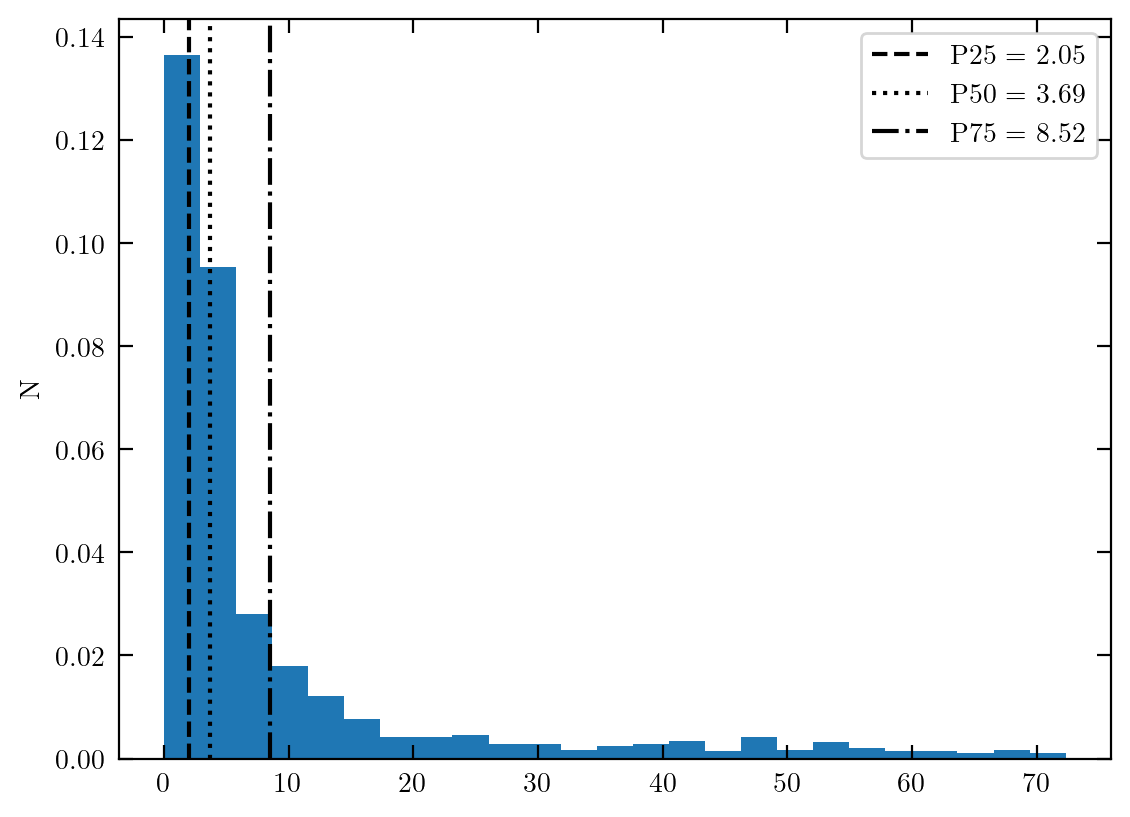

In [8]:
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

x = np.linspace(0,np.max(period_array),100)
plt.hist(np.array(period_array).flatten(),density=1,bins=25)
#plt.plot(x,KDE(x,silverman((np.array(period_array).flatten())),np.array(period_array).flatten()),color='blue')
plt.ylabel('N',fontsize=10)
plt.xlabel(r'$T(r_{0.5}) [Myr]'
plt.axvline(np.nanpercentile(period_array, 25), c='black', linestyle = '--', label=f'P25 = {np.round(np.nanpercentile(np.array(period_array).flatten(), 25),2)}')
plt.axvline(np.nanpercentile((period_array), 50), c='black', linestyle = ':', label=f'P50 = {np.round(np.nanmedian(np.array(period_array).flatten()),2)}')
plt.axvline(np.nanpercentile((period_array), 75), c='black', linestyle = '-.', label=f'P75 = {np.round(np.nanpercentile(np.array(period_array).flatten(), 75),2)}')
plt.legend(fontsize=10)

In [5]:
indices = []
for i in tqdm(range(550)):
    indices.append(np.where(np.array(hf['Snapshot_99']['SubfindID']) == np.intersect1d(circ_subfindID,main_subhalos)[i])[0])

100%|██████████| 550/550 [00:00<00:00, 1197.58it/s]


In [8]:
mass_07_fraction = []
for index in tqdm(range(550)):
    subfindID = np.intersect1d(circ_subfindID,main_subhalos)[index]
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)

    snap = 99
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']
    h = 0.678

    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential')
    DMPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')
    gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
    gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

    particleCoords_bar  = starPos
    particleVels_bar    = starVel #km/s
    particleMass_bar    = starMass * h #1e0 M_sol
    particleCoords_DM = DMPos
    particleMass_DM  = np.ones(len(np.linalg.norm(DMPos,axis=1))) * 3.07367708626464e-05 * h #1e10 _sol
    particleMass_gas    = gasMass * h #1e0 M_sol
    particleCoords_gas = gasPos
    
    # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a*h
    particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)
    particleCoords_DM  = (particleCoords_DM - subhaloPos_i)*a*h
    particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a*h
    
    #Calculating within the stellar half-mass radius
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>0)&(r_bar<=halfmassrad_i))[0]

    J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #kpc*km/s

    spin_vector = make_unit(J)
    #Rotating system to align angular momentum axis and z-axis of the box before calculations 
    z = [[0, 0, 1], [1, 0, 0]]
    rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])
    
    r_DM = np.sqrt(np.sum(particleCoords_DM**2,axis=1))
    r_gas = np.sqrt(np.sum(particleCoords_gas**2,axis=1))
    
    starIndsInDisk = np.where((r_bar>0)&(r_bar<=10*halfmassrad_i))[0]
    DMIndsInDisk = np.where((r_DM>0)&(r_DM<=10*halfmassrad_i))[0]
    gasIndsInDisk = np.where((r_gas>0)&(r_gas<=10*halfmassrad_i))[0]

    rot_starPos = rot.apply(particleCoords_bar[starIndsInDisk])
    rot_starVel = rot.apply(particleVels_bar[starIndsInDisk])
    rot_DMPos = rot.apply(particleCoords_DM[DMIndsInDisk])
    rot_gasPos = rot.apply(particleCoords_gas[gasIndsInDisk])

    massInDisk = particleMass_bar[starIndsInDisk]
    DMInDisk = particleMass_DM[DMIndsInDisk]
    gasInDisk = particleMass_gas[gasIndsInDisk]
    j_z = np.abs(np.cross(rot_starPos,rot_starVel)[:,2])

    pot_star_nbody = agama.Potential(type='Multipole', particles=(rot_starPos, massInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_DM_nbody = agama.Potential(type='Multipole', particles=(rot_DMPos, DMInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_gas_nbody = agama.Potential(type='Multipole', particles=(rot_gasPos, gasInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    joint_pot = agama.Potential(pot_gas_nbody,pot_DM_nbody,pot_star_nbody)

    BE = (joint_pot.potential(rot_starPos) + 0.5*np.linalg.norm(rot_starVel,axis=1)**2)

    Rcirc = joint_pot.Rcirc(E = BE)
    Tcirc = joint_pot.Tcirc(BE)
    j_circ =  2*np.pi * (Rcirc*3.086e16) * Rcirc / (Tcirc * 3.08633328e16)

    mass_tot = []
    for i in (range(len(j_z))):
        if j_z[i]/j_circ[i] > 0.7:
            mass_tot.append(massInDisk[i])

    mass_07_fraction.append(np.sum(mass_tot)/np.sum(massInDisk))

100%|██████████| 550/550 [1:07:42<00:00,  7.39s/it]


In [6]:
G15_frac = np.array(hf['Snapshot_99']['CircAbove07Frac'])[indices]

In [10]:
save_mass_07_fractions = save_name+'AV23_G15_shared_mass_fractions.npy'
np.save(save_mass_07_fractions,mass_07_fraction,allow_pickle=True)

In [7]:
load_mass_07_fractions = save_name+'AV23_G15_shared_mass_fractions.npy'
mass_07_fraction = np.load(load_mass_07_fractions)

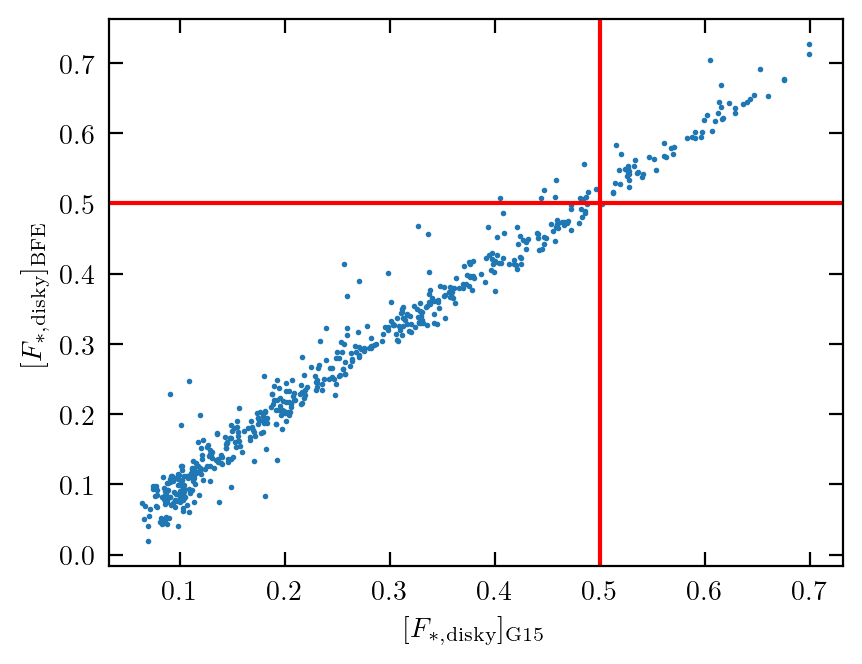

In [10]:
plt.figure(figsize=(4.733,3.55))
plt.scatter(G15_frac, mass_07_fraction,s=1)
plt.xlabel(r'$[F_{*, \mathrm{disky}}]_{\mathrm{G15}}$',fontsize=10)
plt.ylabel(r'$[F_{*, \mathrm{disky}}]_{\mathrm{BFE}}$',fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(0.5,c='r')
plt.axvline(0.5,c='r')
plt.savefig("g15.pdf", format="pdf", bbox_inches="tight")

We see we can recover the galaxies G15 considers disks by our method. We can enforce a slightly higher condition to define the majority to account for any analytical overestimation of disk stars. These cells have some hiccups in systems without gas, which I probably could have coded a better way to skip but didn't.

In [8]:
main_subfindIDs = [j for i,j in enumerate(main_subhalos) if j!=-1]  

In [10]:
final_diskyIDs = []
NaN_fraction = []
total_masses = []
for subfindID in tqdm(main_subfindIDs):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)

    snap = 75
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']
    h = 0.678

    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential')
    DMPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')
    gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
    gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

    particleCoords_bar  = starPos
    particleVels_bar    = starVel #km/s
    particleMass_bar    = starMass * h #1e0 M_sol
    particleCoords_DM = DMPos
    particleMass_DM  = np.ones(len(np.linalg.norm(DMPos,axis=1))) * 3.07367708626464e-05 * h #1e10 _sol
    particleMass_gas    = gasMass * h #1e0 M_sol
    particleCoords_gas = gasPos
    
    # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a*h
    particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)
    particleCoords_DM  = (particleCoords_DM - subhaloPos_i)*a*h
    particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a*h
    
    for i_s in range(len(particleCoords_bar[:,0])):
        if np.linalg.norm(particleCoords_bar[i_s]) == 0:
            particleCoords_bar = np.delete(particleCoords_bar, i_s, axis=0)
            particleVels_bar = np.delete(particleVels_bar, i_s, axis=0)
            particleMass_bar = np.delete(particleMass_bar, i_s)
            break

    for i_dm in range(len(particleCoords_DM[:,0])):
        if np.linalg.norm(particleCoords_DM[i_dm]) == 0:        
            particleCoords_DM = np.delete(particleCoords_DM, i_dm, axis=0)
            particleMass_DM = np.delete(particleMass_DM, i_dm)
            break
            
    #Calculating within the stellar half-mass radius
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>0)&(r_bar<=halfmassrad_i))[0]

    J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #kpc*km/s

    spin_vector = make_unit(J)
    #Rotating system to align angular momentum axis and z-axis of the box before calculations 
    z = [[0, 0, 1], [1, 0, 0]]
    rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])
    
    r_DM = np.sqrt(np.sum(particleCoords_DM**2,axis=1))
    r_gas = np.sqrt(np.sum(particleCoords_gas**2,axis=1))
    
    starIndsInDisk = np.where((r_bar>0)&(r_bar<=10*halfmassrad_i))[0]
    DMIndsInDisk = np.where((r_DM>0)&(r_DM<=10*halfmassrad_i))[0]
    gasIndsInDisk = np.where((r_gas>0)&(r_gas<=10*halfmassrad_i))[0]

    rot_starPos = rot.apply(particleCoords_bar[starIndsInDisk])
    rot_starVel = rot.apply(particleVels_bar[starIndsInDisk])
    rot_DMPos = rot.apply(particleCoords_DM[DMIndsInDisk])
    rot_gasPos = rot.apply(particleCoords_gas[gasIndsInDisk])

    massInDisk = particleMass_bar[starIndsInDisk]
    DMInDisk = particleMass_DM[DMIndsInDisk]
    gasInDisk = particleMass_gas[gasIndsInDisk]
    j_z = np.abs(np.cross(rot_starPos,rot_starVel)[:,2])

    pot_star_nbody = agama.Potential(type='Multipole', particles=(rot_starPos, massInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_DM_nbody = agama.Potential(type='Multipole', particles=(rot_DMPos, DMInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_gas_nbody = agama.Potential(type='Multipole', particles=(rot_gasPos, gasInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    joint_pot = agama.Potential(pot_gas_nbody,pot_DM_nbody,pot_star_nbody)    

    BE = (joint_pot.potential(rot_starPos) + 0.5*np.linalg.norm(rot_starVel,axis=1)**2)

    Rcirc = joint_pot.Rcirc(E = BE)
    Tcirc = joint_pot.Tcirc(BE)
    j_circ =  2*np.pi * (Rcirc*3.086e16) * Rcirc / (Tcirc * 3.08633328e+16)

    mass_tot = []
    for i in (range(len(j_z))):
        if j_z[i]/j_circ[i] > 0.7:
            mass_tot.append(massInDisk[i])
    mass_07_fraction = (np.sum(mass_tot)/np.sum(massInDisk))
    
    if mass_07_fraction > 0.5:
        final_diskyIDs.append(subfindID[0])
    NaN_fraction.append(len(np.where(BE > 0)[0])/len(BE))
    total_masses.append(np.sum(massInDisk))

 50%|█████     | 882/1754 [2:05:48<2:04:22,  8.56s/it]


RuntimeError: Error in creating potential: SplineApprox: incorrect size of the problem

In [11]:
for subfindID in tqdm(main_subfindIDs[883:]):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)

    snap = 75
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']
    h = 0.678

    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential')
    DMPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')
    gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
    gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

    particleCoords_bar  = starPos
    particleVels_bar    = starVel #km/s
    particleMass_bar    = starMass * h #1e0 M_sol
    particleCoords_DM = DMPos
    particleMass_DM  = np.ones(len(np.linalg.norm(DMPos,axis=1))) * 3.07367708626464e-05 * h #1e10 _sol
    particleMass_gas    = gasMass * h #1e0 M_sol
    particleCoords_gas = gasPos
    
    # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a*h
    particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)
    particleCoords_DM  = (particleCoords_DM - subhaloPos_i)*a*h
    particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a*h
    
    for i_s in range(len(particleCoords_bar[:,0])):
        if np.linalg.norm(particleCoords_bar[i_s]) == 0:
            particleCoords_bar = np.delete(particleCoords_bar, i_s, axis=0)
            particleVels_bar = np.delete(particleVels_bar, i_s, axis=0)
            particleMass_bar = np.delete(particleMass_bar, i_s)
            break

    for i_dm in range(len(particleCoords_DM[:,0])):
        if np.linalg.norm(particleCoords_DM[i_dm]) == 0:        
            particleCoords_DM = np.delete(particleCoords_DM, i_dm, axis=0)
            particleMass_DM = np.delete(particleMass_DM, i_dm)
            break
            
    #Calculating within the stellar half-mass radius
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>0)&(r_bar<=halfmassrad_i))[0]

    J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #kpc*km/s

    spin_vector = make_unit(J)
    #Rotating system to align angular momentum axis and z-axis of the box before calculations 
    z = [[0, 0, 1], [1, 0, 0]]
    rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])
    
    r_DM = np.sqrt(np.sum(particleCoords_DM**2,axis=1))
    r_gas = np.sqrt(np.sum(particleCoords_gas**2,axis=1))
    
    starIndsInDisk = np.where((r_bar>0)&(r_bar<=10*halfmassrad_i))[0]
    DMIndsInDisk = np.where((r_DM>0)&(r_DM<=10*halfmassrad_i))[0]
    gasIndsInDisk = np.where((r_gas>0)&(r_gas<=10*halfmassrad_i))[0]

    rot_starPos = rot.apply(particleCoords_bar[starIndsInDisk])
    rot_starVel = rot.apply(particleVels_bar[starIndsInDisk])
    rot_DMPos = rot.apply(particleCoords_DM[DMIndsInDisk])
    rot_gasPos = rot.apply(particleCoords_gas[gasIndsInDisk])

    massInDisk = particleMass_bar[starIndsInDisk]
    DMInDisk = particleMass_DM[DMIndsInDisk]
    gasInDisk = particleMass_gas[gasIndsInDisk]
    j_z = np.abs(np.cross(rot_starPos,rot_starVel)[:,2])

    pot_star_nbody = agama.Potential(type='Multipole', particles=(rot_starPos, massInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_DM_nbody = agama.Potential(type='Multipole', particles=(rot_DMPos, DMInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_gas_nbody = agama.Potential(type='Multipole', particles=(rot_gasPos, gasInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    joint_pot = agama.Potential(pot_gas_nbody,pot_DM_nbody,pot_star_nbody)    

    BE = (joint_pot.potential(rot_starPos) + 0.5*np.linalg.norm(rot_starVel,axis=1)**2)

    Rcirc = joint_pot.Rcirc(E = BE)
    Tcirc = joint_pot.Tcirc(BE)
    j_circ =  2*np.pi * (Rcirc*3.086e16) * Rcirc / (Tcirc * 3.08633328e+16)

    mass_tot = []
    for i in (range(len(j_z))):
        if j_z[i]/j_circ[i] > 0.7:
            mass_tot.append(massInDisk[i])
    mass_07_fraction = (np.sum(mass_tot)/np.sum(massInDisk))
    
    if mass_07_fraction > 0.5:
        final_diskyIDs.append(subfindID[0])
    NaN_fraction.append(len(np.where(BE > 0)[0])/len(BE))
    total_masses.append(np.sum(massInDisk))

 41%|████▏     | 361/871 [33:47<47:44,  5.62s/it]  


TypeError: unsupported operand type(s) for *: 'dict' and 'float'

In [12]:
for subfindID in tqdm(main_subfindIDs[1245:]):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)

    snap = 75
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']
    h = 0.678

    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential')
    DMPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')
    gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
    gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

    particleCoords_bar  = starPos
    particleVels_bar    = starVel #km/s
    particleMass_bar    = starMass * h #1e0 M_sol
    particleCoords_DM = DMPos
    particleMass_DM  = np.ones(len(np.linalg.norm(DMPos,axis=1))) * 3.07367708626464e-05 * h #1e10 _sol
    particleMass_gas    = gasMass * h #1e0 M_sol
    particleCoords_gas = gasPos
    
    # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a*h
    particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)
    particleCoords_DM  = (particleCoords_DM - subhaloPos_i)*a*h
    particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a*h
    
    for i_s in range(len(particleCoords_bar[:,0])):
        if np.linalg.norm(particleCoords_bar[i_s]) == 0:
            particleCoords_bar = np.delete(particleCoords_bar, i_s, axis=0)
            particleVels_bar = np.delete(particleVels_bar, i_s, axis=0)
            particleMass_bar = np.delete(particleMass_bar, i_s)
            break

    for i_dm in range(len(particleCoords_DM[:,0])):
        if np.linalg.norm(particleCoords_DM[i_dm]) == 0:        
            particleCoords_DM = np.delete(particleCoords_DM, i_dm, axis=0)
            particleMass_DM = np.delete(particleMass_DM, i_dm)
            break
            
    #Calculating within the stellar half-mass radius
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>0)&(r_bar<=halfmassrad_i))[0]

    J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #kpc*km/s

    spin_vector = make_unit(J)
    #Rotating system to align angular momentum axis and z-axis of the box before calculations 
    z = [[0, 0, 1], [1, 0, 0]]
    rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])
    
    r_DM = np.sqrt(np.sum(particleCoords_DM**2,axis=1))
    r_gas = np.sqrt(np.sum(particleCoords_gas**2,axis=1))
    
    starIndsInDisk = np.where((r_bar>0)&(r_bar<=10*halfmassrad_i))[0]
    DMIndsInDisk = np.where((r_DM>0)&(r_DM<=10*halfmassrad_i))[0]
    gasIndsInDisk = np.where((r_gas>0)&(r_gas<=10*halfmassrad_i))[0]

    rot_starPos = rot.apply(particleCoords_bar[starIndsInDisk])
    rot_starVel = rot.apply(particleVels_bar[starIndsInDisk])
    rot_DMPos = rot.apply(particleCoords_DM[DMIndsInDisk])
    rot_gasPos = rot.apply(particleCoords_gas[gasIndsInDisk])

    massInDisk = particleMass_bar[starIndsInDisk]
    DMInDisk = particleMass_DM[DMIndsInDisk]
    gasInDisk = particleMass_gas[gasIndsInDisk]
    j_z = np.abs(np.cross(rot_starPos,rot_starVel)[:,2])

    pot_star_nbody = agama.Potential(type='Multipole', particles=(rot_starPos, massInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_DM_nbody = agama.Potential(type='Multipole', particles=(rot_DMPos, DMInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_gas_nbody = agama.Potential(type='Multipole', particles=(rot_gasPos, gasInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    joint_pot = agama.Potential(pot_gas_nbody,pot_DM_nbody,pot_star_nbody)    

    BE = (joint_pot.potential(rot_starPos) + 0.5*np.linalg.norm(rot_starVel,axis=1)**2)

    Rcirc = joint_pot.Rcirc(E = BE)
    Tcirc = joint_pot.Tcirc(BE)
    j_circ =  2*np.pi * (Rcirc*3.086e16) * Rcirc / (Tcirc * 3.08633328e+16)

    mass_tot = []
    for i in (range(len(j_z))):
        if j_z[i]/j_circ[i] > 0.7:
            mass_tot.append(massInDisk[i])
    mass_07_fraction = (np.sum(mass_tot)/np.sum(massInDisk))
    
    if mass_07_fraction > 0.5:
        final_diskyIDs.append(subfindID[0])
    NaN_fraction.append(len(np.where(BE > 0)[0])/len(BE))
    total_masses.append(np.sum(massInDisk))

 78%|███████▊  | 396/509 [27:35<07:52,  4.18s/it] 


TypeError: unsupported operand type(s) for *: 'dict' and 'float'

In [13]:
for subfindID in tqdm(main_subfindIDs[1642:]):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)

    snap = 75
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']
    h = 0.678

    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential')
    DMPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')
    gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
    gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

    particleCoords_bar  = starPos
    particleVels_bar    = starVel #km/s
    particleMass_bar    = starMass * h #1e0 M_sol
    particleCoords_DM = DMPos
    particleMass_DM  = np.ones(len(np.linalg.norm(DMPos,axis=1))) * 3.07367708626464e-05 * h #1e10 _sol
    particleMass_gas    = gasMass * h #1e0 M_sol
    particleCoords_gas = gasPos
    
    # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a*h
    particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)
    particleCoords_DM  = (particleCoords_DM - subhaloPos_i)*a*h
    particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a*h
    
    for i_s in range(len(particleCoords_bar[:,0])):
        if np.linalg.norm(particleCoords_bar[i_s]) == 0:
            particleCoords_bar = np.delete(particleCoords_bar, i_s, axis=0)
            particleVels_bar = np.delete(particleVels_bar, i_s, axis=0)
            particleMass_bar = np.delete(particleMass_bar, i_s)
            break

    for i_dm in range(len(particleCoords_DM[:,0])):
        if np.linalg.norm(particleCoords_DM[i_dm]) == 0:        
            particleCoords_DM = np.delete(particleCoords_DM, i_dm, axis=0)
            particleMass_DM = np.delete(particleMass_DM, i_dm)
            break
            
    #Calculating within the stellar half-mass radius
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>0)&(r_bar<=halfmassrad_i))[0]

    J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #kpc*km/s

    spin_vector = make_unit(J)
    #Rotating system to align angular momentum axis and z-axis of the box before calculations 
    z = [[0, 0, 1], [1, 0, 0]]
    rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])
    
    r_DM = np.sqrt(np.sum(particleCoords_DM**2,axis=1))
    r_gas = np.sqrt(np.sum(particleCoords_gas**2,axis=1))
    
    starIndsInDisk = np.where((r_bar>0)&(r_bar<=10*halfmassrad_i))[0]
    DMIndsInDisk = np.where((r_DM>0)&(r_DM<=10*halfmassrad_i))[0]
    gasIndsInDisk = np.where((r_gas>0)&(r_gas<=10*halfmassrad_i))[0]

    rot_starPos = rot.apply(particleCoords_bar[starIndsInDisk])
    rot_starVel = rot.apply(particleVels_bar[starIndsInDisk])
    rot_DMPos = rot.apply(particleCoords_DM[DMIndsInDisk])
    rot_gasPos = rot.apply(particleCoords_gas[gasIndsInDisk])

    massInDisk = particleMass_bar[starIndsInDisk]
    DMInDisk = particleMass_DM[DMIndsInDisk]
    gasInDisk = particleMass_gas[gasIndsInDisk]
    j_z = np.abs(np.cross(rot_starPos,rot_starVel)[:,2])

    pot_star_nbody = agama.Potential(type='Multipole', particles=(rot_starPos, massInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_DM_nbody = agama.Potential(type='Multipole', particles=(rot_DMPos, DMInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_gas_nbody = agama.Potential(type='Multipole', particles=(rot_gasPos, gasInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    joint_pot = agama.Potential(pot_gas_nbody,pot_DM_nbody,pot_star_nbody)    

    BE = (joint_pot.potential(rot_starPos) + 0.5*np.linalg.norm(rot_starVel,axis=1)**2)

    Rcirc = joint_pot.Rcirc(E = BE)
    Tcirc = joint_pot.Tcirc(BE)
    j_circ =  2*np.pi * (Rcirc*3.086e16) * Rcirc / (Tcirc * 3.08633328e+16)

    mass_tot = []
    for i in (range(len(j_z))):
        if j_z[i]/j_circ[i] > 0.7:
            mass_tot.append(massInDisk[i])
    mass_07_fraction = (np.sum(mass_tot)/np.sum(massInDisk))
    
    if mass_07_fraction > 0.5:
        final_diskyIDs.append(subfindID[0])
    NaN_fraction.append(len(np.where(BE > 0)[0])/len(BE))
    total_masses.append(np.sum(massInDisk))

 14%|█▍        | 16/112 [01:13<07:21,  4.60s/it]


TypeError: unsupported operand type(s) for *: 'dict' and 'float'

In [14]:
for subfindID in tqdm(main_subfindIDs[1657:]):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)

    snap = 75
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']
    h = 0.678

    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential')
    DMPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')
    gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
    gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

    particleCoords_bar  = starPos
    particleVels_bar    = starVel #km/s
    particleMass_bar    = starMass * h #1e0 M_sol
    particleCoords_DM = DMPos
    particleMass_DM  = np.ones(len(np.linalg.norm(DMPos,axis=1))) * 3.07367708626464e-05 * h #1e10 _sol
    particleMass_gas    = gasMass * h #1e0 M_sol
    particleCoords_gas = gasPos
    
    # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a*h
    particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)
    particleCoords_DM  = (particleCoords_DM - subhaloPos_i)*a*h
    particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a*h
    
    for i_s in range(len(particleCoords_bar[:,0])):
        if np.linalg.norm(particleCoords_bar[i_s]) == 0:
            particleCoords_bar = np.delete(particleCoords_bar, i_s, axis=0)
            particleVels_bar = np.delete(particleVels_bar, i_s, axis=0)
            particleMass_bar = np.delete(particleMass_bar, i_s)
            break

    for i_dm in range(len(particleCoords_DM[:,0])):
        if np.linalg.norm(particleCoords_DM[i_dm]) == 0:        
            particleCoords_DM = np.delete(particleCoords_DM, i_dm, axis=0)
            particleMass_DM = np.delete(particleMass_DM, i_dm)
            break
            
    #Calculating within the stellar half-mass radius
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>0)&(r_bar<=halfmassrad_i))[0]

    J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #kpc*km/s

    spin_vector = make_unit(J)
    #Rotating system to align angular momentum axis and z-axis of the box before calculations 
    z = [[0, 0, 1], [1, 0, 0]]
    rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])
    
    r_DM = np.sqrt(np.sum(particleCoords_DM**2,axis=1))
    r_gas = np.sqrt(np.sum(particleCoords_gas**2,axis=1))
    
    starIndsInDisk = np.where((r_bar>0)&(r_bar<=10*halfmassrad_i))[0]
    DMIndsInDisk = np.where((r_DM>0)&(r_DM<=10*halfmassrad_i))[0]
    gasIndsInDisk = np.where((r_gas>0)&(r_gas<=10*halfmassrad_i))[0]

    rot_starPos = rot.apply(particleCoords_bar[starIndsInDisk])
    rot_starVel = rot.apply(particleVels_bar[starIndsInDisk])
    rot_DMPos = rot.apply(particleCoords_DM[DMIndsInDisk])
    rot_gasPos = rot.apply(particleCoords_gas[gasIndsInDisk])

    massInDisk = particleMass_bar[starIndsInDisk]
    DMInDisk = particleMass_DM[DMIndsInDisk]
    gasInDisk = particleMass_gas[gasIndsInDisk]
    j_z = np.abs(np.cross(rot_starPos,rot_starVel)[:,2])

    pot_star_nbody = agama.Potential(type='Multipole', particles=(rot_starPos, massInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_DM_nbody = agama.Potential(type='Multipole', particles=(rot_DMPos, DMInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_gas_nbody = agama.Potential(type='Multipole', particles=(rot_gasPos, gasInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    joint_pot = agama.Potential(pot_gas_nbody,pot_DM_nbody,pot_star_nbody)    

    BE = (joint_pot.potential(rot_starPos) + 0.5*np.linalg.norm(rot_starVel,axis=1)**2)

    Rcirc = joint_pot.Rcirc(E = BE)
    Tcirc = joint_pot.Tcirc(BE)
    j_circ =  2*np.pi * (Rcirc*3.086e16) * Rcirc / (Tcirc * 3.08633328e+16)

    mass_tot = []
    for i in (range(len(j_z))):
        if j_z[i]/j_circ[i] > 0.7:
            mass_tot.append(massInDisk[i])
    mass_07_fraction = (np.sum(mass_tot)/np.sum(massInDisk))
    
    if mass_07_fraction > 0.5:
        final_diskyIDs.append(subfindID[0])
    NaN_fraction.append(len(np.where(BE > 0)[0])/len(BE))
    total_masses.append(np.sum(massInDisk))

  1%|          | 1/97 [00:16<26:32, 16.59s/it]


TypeError: unsupported operand type(s) for *: 'dict' and 'float'

In [15]:
for subfindID in tqdm(main_subfindIDs[1659:]):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)

    snap = 75
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']
    h = 0.678

    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential')
    DMPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')
    gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
    gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

    particleCoords_bar  = starPos
    particleVels_bar    = starVel #km/s
    particleMass_bar    = starMass * h #1e0 M_sol
    particleCoords_DM = DMPos
    particleMass_DM  = np.ones(len(np.linalg.norm(DMPos,axis=1))) * 3.07367708626464e-05 * h #1e10 _sol
    particleMass_gas    = gasMass * h #1e0 M_sol
    particleCoords_gas = gasPos
    
    # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a*h
    particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)
    particleCoords_DM  = (particleCoords_DM - subhaloPos_i)*a*h
    particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a*h
    
    for i_s in range(len(particleCoords_bar[:,0])):
        if np.linalg.norm(particleCoords_bar[i_s]) == 0:
            particleCoords_bar = np.delete(particleCoords_bar, i_s, axis=0)
            particleVels_bar = np.delete(particleVels_bar, i_s, axis=0)
            particleMass_bar = np.delete(particleMass_bar, i_s)
            break

    for i_dm in range(len(particleCoords_DM[:,0])):
        if np.linalg.norm(particleCoords_DM[i_dm]) == 0:        
            particleCoords_DM = np.delete(particleCoords_DM, i_dm, axis=0)
            particleMass_DM = np.delete(particleMass_DM, i_dm)
            break
            
    #Calculating within the stellar half-mass radius
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>0)&(r_bar<=halfmassrad_i))[0]

    J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #kpc*km/s

    spin_vector = make_unit(J)
    #Rotating system to align angular momentum axis and z-axis of the box before calculations 
    z = [[0, 0, 1], [1, 0, 0]]
    rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])
    
    r_DM = np.sqrt(np.sum(particleCoords_DM**2,axis=1))
    r_gas = np.sqrt(np.sum(particleCoords_gas**2,axis=1))
    
    starIndsInDisk = np.where((r_bar>0)&(r_bar<=10*halfmassrad_i))[0]
    DMIndsInDisk = np.where((r_DM>0)&(r_DM<=10*halfmassrad_i))[0]
    gasIndsInDisk = np.where((r_gas>0)&(r_gas<=10*halfmassrad_i))[0]

    rot_starPos = rot.apply(particleCoords_bar[starIndsInDisk])
    rot_starVel = rot.apply(particleVels_bar[starIndsInDisk])
    rot_DMPos = rot.apply(particleCoords_DM[DMIndsInDisk])
    rot_gasPos = rot.apply(particleCoords_gas[gasIndsInDisk])

    massInDisk = particleMass_bar[starIndsInDisk]
    DMInDisk = particleMass_DM[DMIndsInDisk]
    gasInDisk = particleMass_gas[gasIndsInDisk]
    j_z = np.abs(np.cross(rot_starPos,rot_starVel)[:,2])

    pot_star_nbody = agama.Potential(type='Multipole', particles=(rot_starPos, massInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_DM_nbody = agama.Potential(type='Multipole', particles=(rot_DMPos, DMInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    pot_gas_nbody = agama.Potential(type='Multipole', particles=(rot_gasPos, gasInDisk), symmetry='None', 
                                    rmin=0.3,rmax=10*halfmassrad_i,gridSizeR=25,lmax=8)
    joint_pot = agama.Potential(pot_gas_nbody,pot_DM_nbody,pot_star_nbody)    

    BE = (joint_pot.potential(rot_starPos) + 0.5*np.linalg.norm(rot_starVel,axis=1)**2)

    Rcirc = joint_pot.Rcirc(E = BE)
    Tcirc = joint_pot.Tcirc(BE)
    j_circ =  2*np.pi * (Rcirc*3.086e16) * Rcirc / (Tcirc * 3.08633328e+16)

    mass_tot = []
    for i in (range(len(j_z))):
        if j_z[i]/j_circ[i] > 0.7:
            mass_tot.append(massInDisk[i])
    mass_07_fraction = (np.sum(mass_tot)/np.sum(massInDisk))
    
    if mass_07_fraction > 0.5:
        final_diskyIDs.append(subfindID[0])
    NaN_fraction.append(len(np.where(BE > 0)[0])/len(BE))
    total_masses.append(np.sum(massInDisk))

100%|██████████| 95/95 [04:33<00:00,  2.88s/it]


In [16]:
len(final_diskyIDs)

40

In [18]:
final_GrNr = []
for subfindID in final_diskyIDs:
    GrNr = il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr']
    final_GrNr.append(il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

In [20]:
np.sort(final_GrNr)

array([ 516,  587,  601,  748,  772,  787,  816,  879,  884,  905,  920,
        931,  940,  974,  982,  985, 1023, 1026, 1044, 1182, 1202, 1238,
       1291, 1292, 1346, 1400, 1464, 1628, 1694, 1738, 1771, 1814, 1970,
       2262, 2340, 2410, 2555, 2968, 3104, 3247], dtype=int32)

In [22]:
for ID in final_diskyIDs:
    if ID not in final_65_diskyIDs:
        print('new galaxy dropped?')

In [23]:
save_diskyIDs = save_name+'real_final_diskyIDs.npy'
np.save(save_diskyIDs,final_diskyIDs,allow_pickle=True)

save_NaN_fraction = save_name+'NaN_fractions.npy'
np.save(save_NaN_fraction,NaN_fraction,allow_pickle=True)

save_total_masses = save_name+'total_masses.npy'
np.save(save_total_masses,total_masses,allow_pickle=True)

In [9]:
total_masses = np.load('/home/tnguser/postprocessing/circularity_study/total_masses.npy')
NaN_fraction = np.load('/home/tnguser/postprocessing/circularity_study/NaN_fractions.npy')

Occasionally, AGAMA will calculate positive binding energies, which will yield NaN values in further calculations. We present the fraction of how many particles have positive binding energies across the systems --- which thankfully, isn't much and also supports the validity of our method that all the systems have little to not positive binding energy errors. 

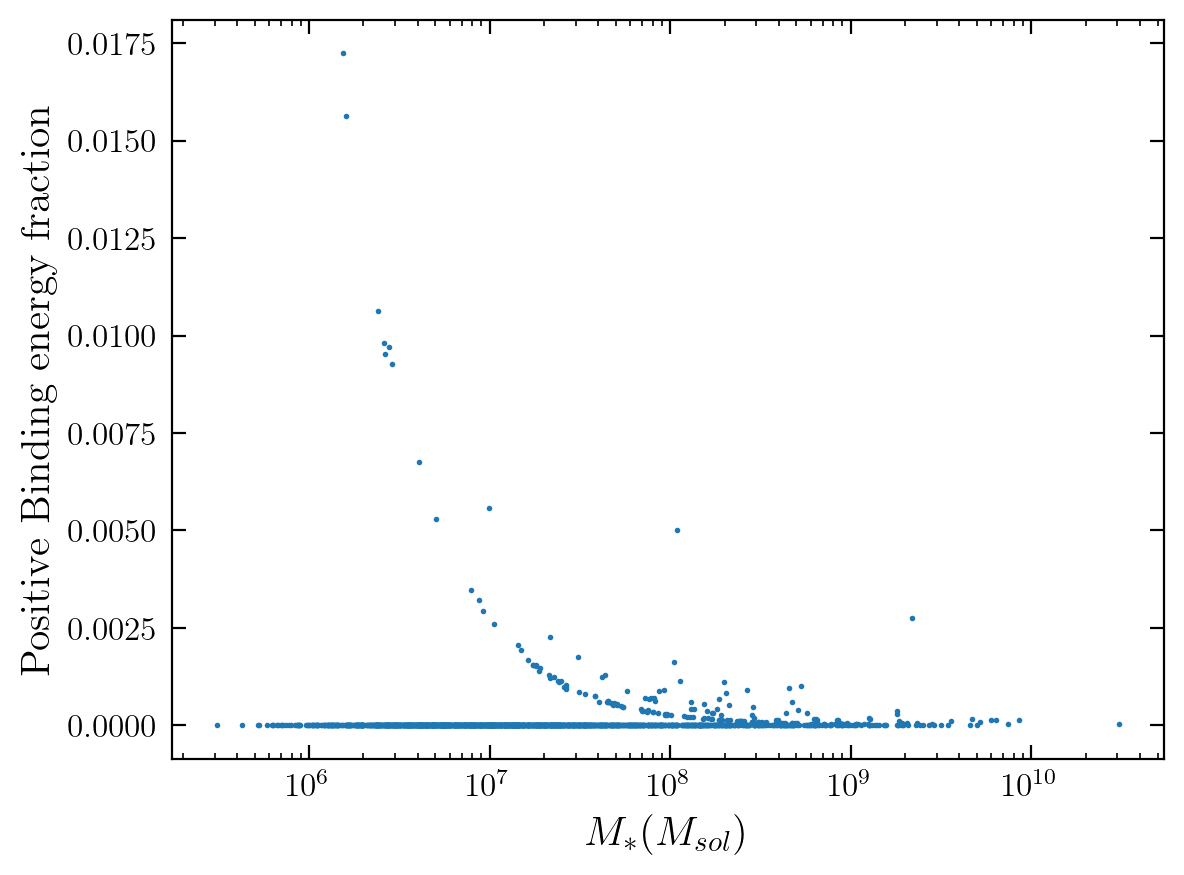

In [17]:
plt.scatter(1e10*np.array(total_masses),NaN_fraction,s=1)
plt.xlabel('$M_* (M_{sol})$')
plt.ylabel('Positive Binding energy fraction')
plt.xscale('log')

Below are specific angular momentum calculations plotted as functions of mass, which I used when this project started to see how much the G15 mass cut affected the exclusion of AV23's galaxies (spoiler: it was entirely the mass cut that caused the exclusion).

In [13]:
j = []
genel_j = []
for i in tqdm(range(550)):
    subfindID = np.intersect1d(circ_subfindID,main_subhalos)[i]
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)

    snap = 99
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']

    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential') 

    particleCoords_bar  = starPos
    particleVels_bar    = starVel #km/s
    particleMass_bar    = starMass * 1e10 #M_sol/h

    # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
    particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)

    #Calculating within the stellar half-mass radius
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>0)&(r_bar<=halfmassrad_i))[0]

    J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #h^{-2} kpc*km/s

    spin_vector = make_unit(J)
    #Rotating system to align angular momentum axis and z-axis of the box before calculations 
    z = [[0, 0, 1], [1, 0, 0]]
    rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])

    indsInBounds = np.where((r_bar>0)&(r_bar<=10*halfmassrad_i))[0]

    j.append(np.sum(np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds])))
    genel_j.append(np.array(hf['Snapshot_99']['SpecificAngMom'])[np.where(np.array(hf['Snapshot_99']['SubfindID'] == np.intersect1d(circ_subfindID,main_subhalos)[i]))[0]])

100%|██████████| 550/550 [07:58<00:00,  1.15it/s]


Text(0, 0.5, 'Total $j_* (h^{-2}*kpc*km/s)$')

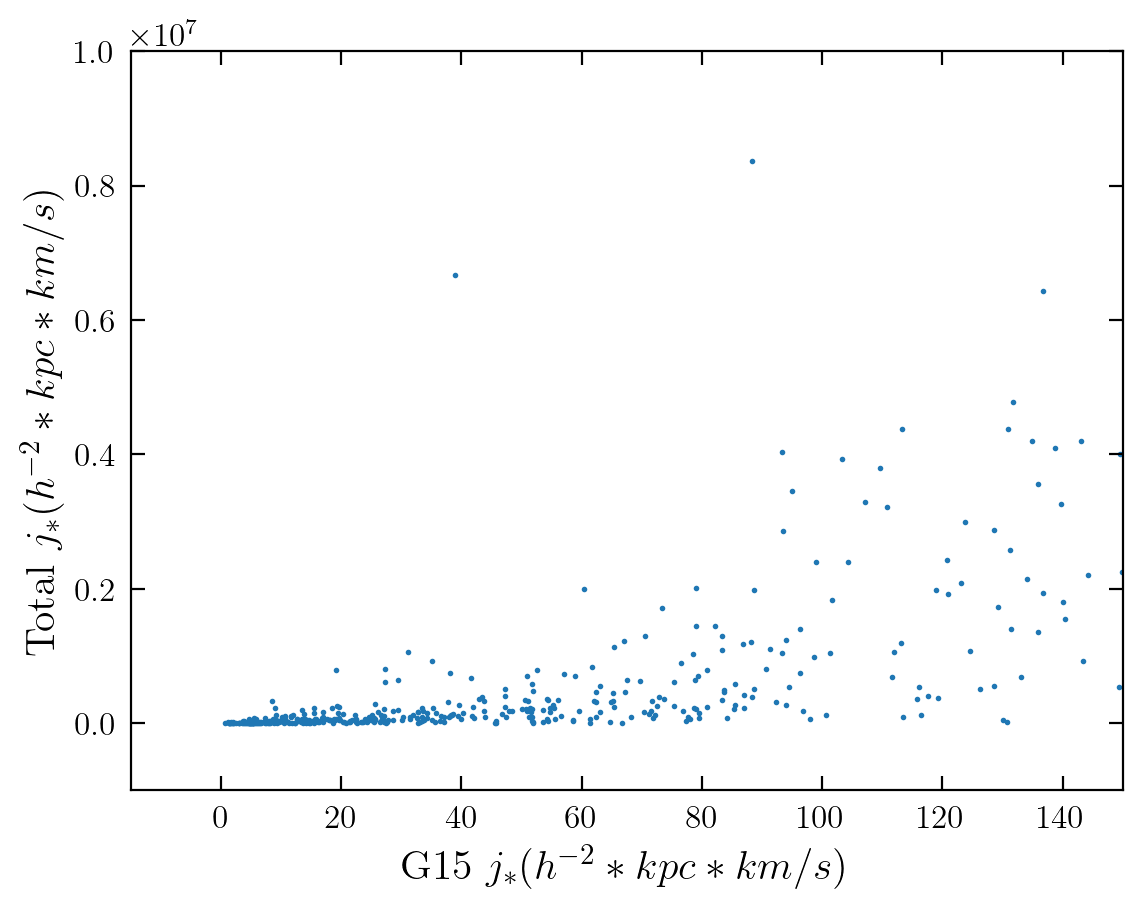

In [14]:
plt.scatter(genel_j,np.abs(j),s=1)
plt.xlim(-15,150)
plt.ylim(-1e6,1e7)
plt.xlabel('G15 $j_* (h^{-2}*kpc*km/s)$')
plt.ylabel('Total $j_* (h^{-2}*kpc*km/s)$')

In [15]:
j_tot_list = []
total_mass_list = []
for subfindID in tqdm(np.intersect1d(circ_subfindID,main_subhalos)):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)

    snap = 99
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']

    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential') 

    particleCoords_bar  = starPos
    particleVels_bar    = starVel
    particleMass_bar    = starMass * 1e10 

    # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a 
    particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)

    innerRad = 0
    outerRad = 10*halfmassrad_i
    #Calculating with 10 times the stellar half-mass radius
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>innerRad)&(r_bar<=outerRad))[0]

    J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #h^{-2} kpc*km/s

    spin_vector = make_unit(J)
    #Rotating system to align angular momentum axis and z-axis of the box before calculations 
    z = [[0, 0, 1], [1, 0, 0]]
    rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])

    rot_starPos = rot.apply(particleCoords_bar[indsInBounds])
    rot_starVel = rot.apply(particleVels_bar[indsInBounds])

    j_tot = np.linalg.norm(np.sum(np.cross(rot_starPos,rot_starVel),axis=0)) #h^[-2]*kpc*km/s
    j_tot_list.append(j_tot)
    total_mass_list.append(np.sum(particleMass_bar))

100%|██████████| 550/550 [06:46<00:00,  1.35it/s]


In [16]:
genel_IDs = []
not_genel_IDs = []
for subfindID in tqdm(main_subfindIDs):
    if subfindID in circ_subfindID:
        genel_IDs.append(subfindID)
    else:
        not_genel_IDs.append(subfindID)

100%|██████████| 1754/1754 [01:33<00:00, 18.71it/s]


In [17]:
not_genel_j_tot_list = []
not_genel_total_mass_list = []
for subfindID in tqdm(not_genel_IDs):
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'],onlyMPB=True)

    snap = 99
    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']

    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    starU = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Potential') 

    particleCoords_bar  = starPos
    particleVels_bar    = starVel #km/s
    particleMass_bar    = starMass * 1e10 #M_sol

    # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
    particleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a)

    innerRad = 0
    outerRad = 10*halfmassrad_i
    #Calculating with 10 times the stellar half-mass radius
    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    indsInBounds = np.where((r_bar>innerRad)&(r_bar<=outerRad))[0]

    J = np.sum(particleMass_bar[indsInBounds].reshape(-1,1)*np.cross(particleCoords_bar[indsInBounds],particleVels_bar[indsInBounds]),axis=0) #h^{-2} kpc*km/s

    spin_vector = make_unit(J)
    #Rotating system to align angular momentum axis and z-axis of the box before calculations 
    z = [[0, 0, 1], [1, 0, 0]]
    rot, rssd, sens = R.align_vectors(z, [spin_vector, [1,0,0]], return_sensitivity=True, weights=[100, .1])

    rot_starPos = rot.apply(particleCoords_bar[indsInBounds])
    rot_starVel = rot.apply(particleVels_bar[indsInBounds])

    j_tot = np.linalg.norm(np.sum(np.cross(rot_starPos,rot_starVel),axis=0)) #h^[-2]*kpc*km/s
    not_genel_j_tot_list.append(j_tot)
    not_genel_total_mass_list.append(np.sum(particleMass_bar))

100%|██████████| 1204/1204 [15:27<00:00,  1.30it/s]


In [18]:
genel_j_list = []
for i in range(550):
    j = np.array(hf['Snapshot_99']['SpecificAngMom'])[np.where(np.array(circ_subfindID)== np.intersect1d(circ_subfindID,main_subhalos)[i])[0]]
    genel_j_list.append(j)

In [19]:
not_genel_total_halo_mass_list = []
for subfindID in tqdm(not_genel_IDs):
    mass = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloMass'])
    not_genel_total_halo_mass_list.append(mass)

100%|██████████| 1204/1204 [00:26<00:00, 45.22it/s]


In [20]:
total_halo_mass_list = []
for subfindID in tqdm(np.intersect1d(circ_subfindID,main_subhalos)):
    mass = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloMass'])
    total_halo_mass_list.append(mass)

100%|██████████| 550/550 [00:11<00:00, 47.31it/s]


[]

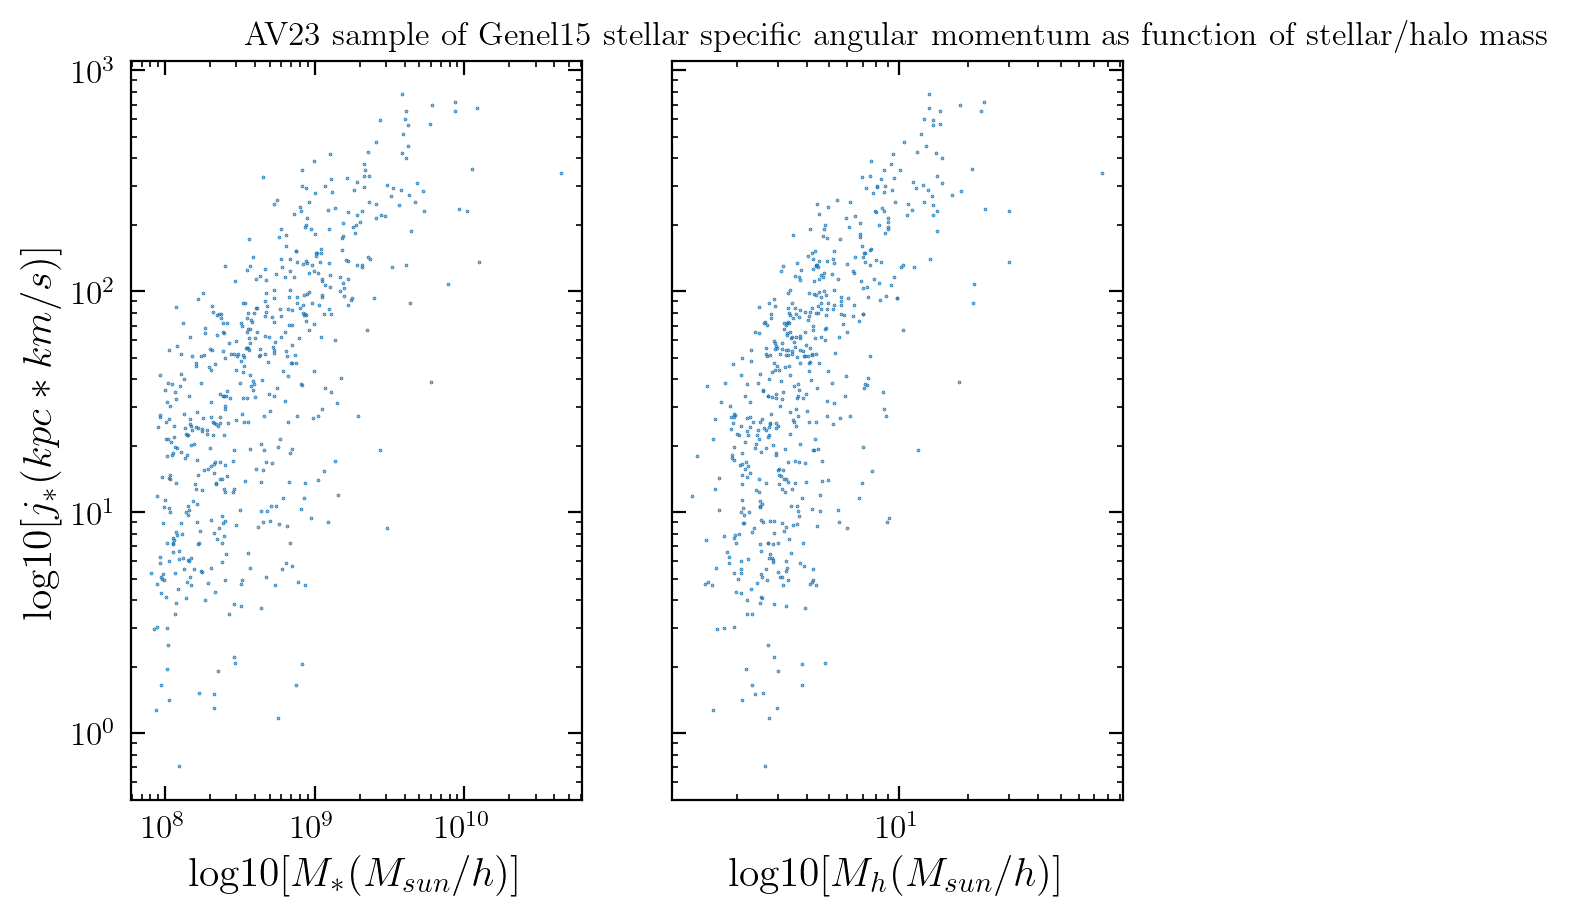

In [21]:
f, ((ax1, ax2)) = plt.subplots(1, 2, sharey=True)
plt.title('AV23 sample of Genel15 stellar specific angular momentum as function of stellar/halo mass')
ax1.scatter(total_mass_list,genel_j_list,s=0.1)#,label='G15 and AV23 shared'
ax2.scatter(total_halo_mass_list,genel_j_list,s=0.1)#,label='G15 and AV23 shared')
ax1.set_xlabel('log10[$M_* (M_{sun}/h)]$')
ax1.set_ylabel('log10[$j_* (kpc*km/s)$]')
ax2.set_xlabel('log10[$M_h (M_{sun}/h)]$')
ax1.loglog()
ax2.loglog()

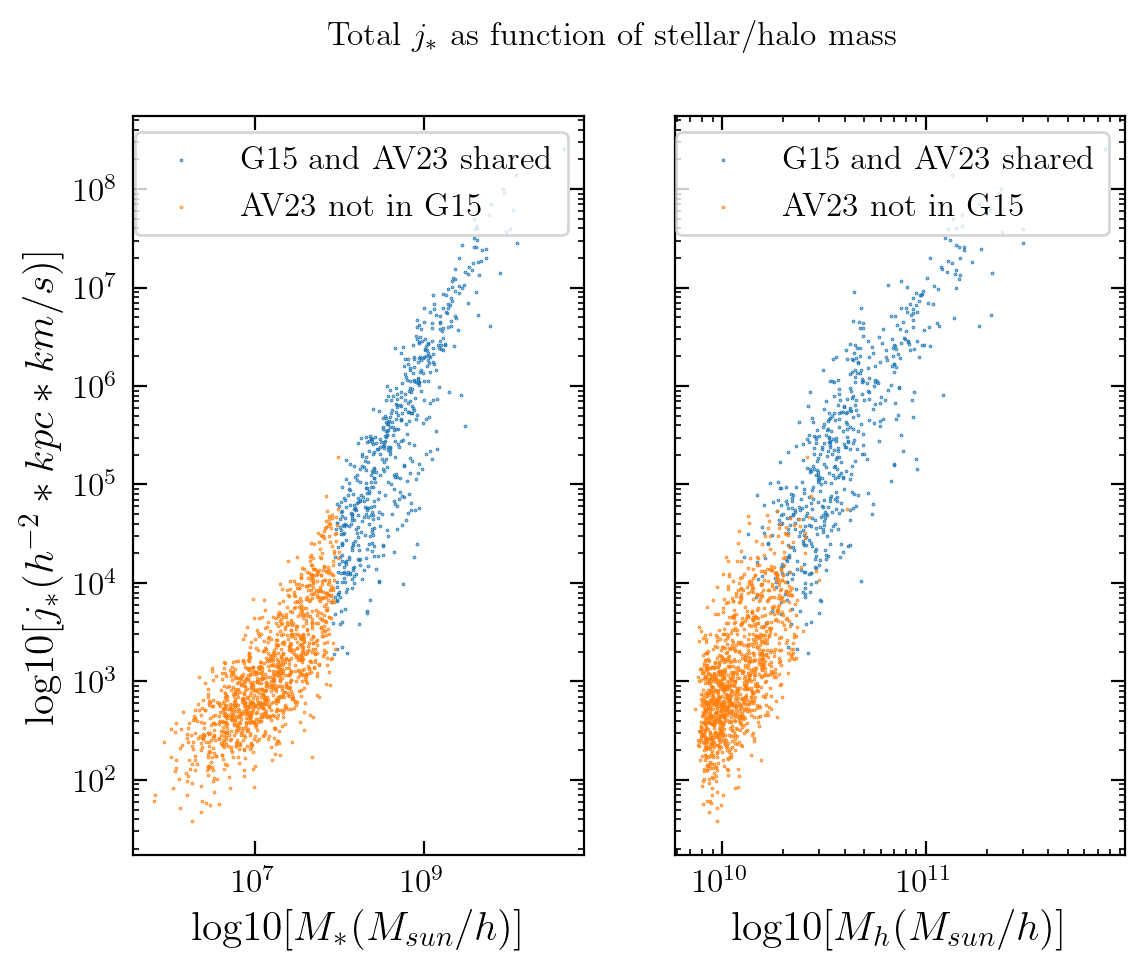

In [22]:
f, ((ax1, ax2)) = plt.subplots(1, 2, sharey=True)
f.suptitle('Total $j_*$ as function of stellar/halo mass')

ax1.scatter(total_mass_list,j_tot_list,s=0.1,label='G15 and AV23 shared')
ax1.scatter(not_genel_total_mass_list,not_genel_j_tot_list,s=0.1,label='AV23 not in G15')
ax1.set_xlabel('log10[$M_* (M_{sun}/h)]$')
ax1.set_ylabel('log10[$j_* (h^{-2}*kpc*km/s)$]')
ax1.loglog()
ax1.legend()

ax2.scatter(1e10*np.array(total_halo_mass_list),j_tot_list,s=0.1,label='G15 and AV23 shared')
ax2.scatter(np.array(not_genel_total_halo_mass_list)*1e10,not_genel_j_tot_list,s=0.1,label='AV23 not in G15')
ax2.set_xlabel('log10[$M_h (M_{sun}/h)]$')
ax2.loglog()
ax2.legend()

We can observe here that the entire cut on AV23's galaxies was a result of insufficient stellar mass. The scatter increases in the lower mass area of the $j_*$ stellar mass function, but that can also be attributed to a larger number of datapoints being plotted rather than the correlation not holding as well. This mass segregation blurs when we plot the $j_*$ halo mass function, but it generally holds to expectation that reflects the stellar-to-halo-mass relation, where we reach the peak stellar mass before it can decline due to dark matter halos too large for peak star formation.